# Rice Classification - AutoML & Visualization

## Abstract


> This is a set of data created for rice classification. I recommend using this dataset for educational purposes, for practice and to acquire the necessary knowledge. It is modified dataset from this resource: link Jasmine - 1, Gonen - 0.



> This dataset consists of:
1. 10 physical characteristics of rice i.e. 
Area, 
MajorAxisLength, 
MinorAxisLength, 
Eccentricity, 
ConvexArea, 
EquivDiameter, 
Extent, 
Perimeter, 
Roundness, 
AspectRation - **The independent variables**. 
2. The class of rice - **The dependent variable**.
3. There are totally 18185 rice samples.




In [ ]:
!pip install eli5
!pip install tabulate
!pip install h2o

In [417]:
# installing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.express as px

import seaborn as sns
import missingno as msno
import warnings
import copy

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
pyo.init_notebook_mode()
warnings.filterwarnings("ignore")

## Data checking & cleaning

In [418]:
# Import dataset and display all features
data = pd.read_csv('https://raw.githubusercontent.com/YongyanDeng/ML_Data_Cleaning_and_Feature_Selection_RiceClassfication/main/riceClassification.csv')
data = data.drop(["id"], axis=1)
data.describe()

Area  MajorAxisLength  MinorAxisLength  Eccentricity  \
count  18185.000000     18185.000000     18185.000000  18185.000000   
mean    7036.492989       151.680754        59.807851      0.915406   
std     1467.197150        12.376402        10.061653      0.030575   
min     2522.000000        74.133114        34.409894      0.676647   
25%     5962.000000       145.675910        51.393151      0.891617   
50%     6660.000000       153.883750        55.724288      0.923259   
75%     8423.000000       160.056214        70.156593      0.941372   
max    10210.000000       183.211434        82.550762      0.966774   

         ConvexArea  EquivDiameter        Extent     Perimeter     Roundness  \
count  18185.000000   18185.000000  18185.000000  18185.000000  18185.000000   
mean    7225.817872      94.132952      0.616653    351.606949      0.707998   
std     1502.006571       9.906250      0.104389     29.500620      0.067310   
min     2579.000000      56.666658      0.383239    197.015000      0.174590   
25%     6125.000000      87.126656      0.538530    333.990000      0.650962   
50%     6843.000000      92.085696      0.601194    353.088000      0.701941   
75%     8645.000000     103.559146      0.695664    373.003000      0.769280   
max    11008.000000     114.016559      0.886573    508.511000      0.904748   

       AspectRation         Class  
count  18185.000000  18185.000000  
mean       2.599081      0.549079  
std        0.434836      0.497599  
min        1.358128      0.000000  
25%        2.208527      0.000000  
50%        2.602966      1.000000  
75%        2.964101      1.000000  
max        3.911845      1.000000

In [419]:
data.isna().sum()

Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64

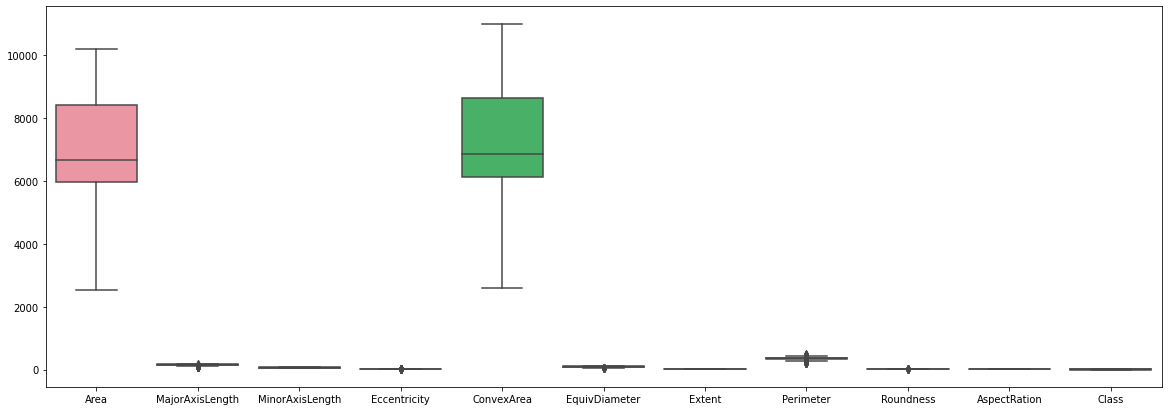

In [420]:
plt.figure(figsize=(20,7))
sns.boxplot(data=data)



> From the graph above, it shows that it's difficult to analyze if the ranges of predictors are reasonable or not. Next, I will normalize the data to better understand the ranges.



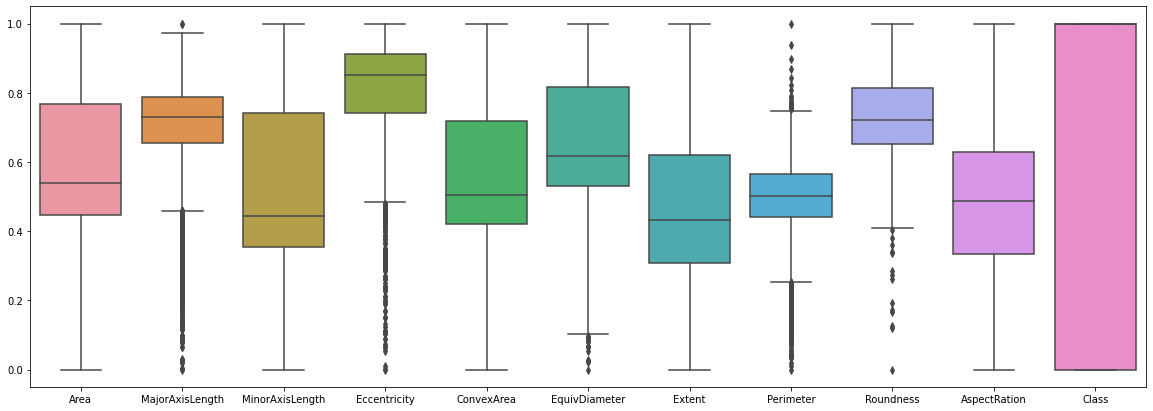

In [421]:
data_std = copy.deepcopy(data);
data_std = pd.get_dummies(data_std)

from sklearn import preprocessing

for i in range(0, 11):
  t = data_std[[data_std.columns[i]]].values.astype(data_std.dtypes[i])

  min_max_scaler = preprocessing.MinMaxScaler()

  t_scaled = min_max_scaler.fit_transform(t)
  data_std[[data_std.columns[i]]] = pd.DataFrame(t_scaled)

plt.figure(figsize=(20,7))
sns.boxplot(data=data_std)



> 1. After normalizing all variables, it can be clearly observed that "MajorAxisLength", "Eccentricity", "EquivDiameter", "Perimeter", "Roundness" have outliers, which requires future processing. 
2. The value of "Class" is either '0' or '1', which is reasonable.
3. The majority value of "MajorAxisLength" is larger than the majority value of "MinorAxisLength", which is reasonable.

## Train & test datasets preprocess

In [422]:
Y = ["Class"]
X = [c for c in data_std.columns if c not in Y]
train, test = train_test_split(data_std, test_size=0.2)

In [423]:
train.describe()

Area  MajorAxisLength  MinorAxisLength  Eccentricity  \
count  14548.000000     14548.000000     14548.000000  14548.000000   
mean       0.587266         0.711767         0.526986      0.823553   
std        0.190816         0.113088         0.209185      0.105626   
min        0.000000         0.002117         0.000000      0.001300   
25%        0.447581         0.656361         0.352453      0.741291   
50%        0.537981         0.732318         0.441739      0.853166   
75%        0.767690         0.788549         0.743415      0.913009   
max        1.000000         1.000000         1.000000      0.998417   

         ConvexArea  EquivDiameter        Extent     Perimeter     Roundness  \
count  14548.000000   14548.000000  14548.000000  14548.000000  14548.000000   
mean       0.551340       0.653356      0.463889      0.496663      0.729934   
std        0.178125       0.172590      0.207647      0.094350      0.092190   
min        0.000000       0.000000      0.000000      0.000000      0.000000   
25%        0.420690       0.531253      0.308528      0.440531      0.651829   
50%        0.505695       0.617354      0.433662      0.501331      0.720224   
75%        0.720489       0.817763      0.621622      0.564819      0.814272   
max        1.000000       1.000000      1.000000      0.936840      1.000000   

       AspectRation         Class  
count  14548.000000  14548.000000  
mean       0.487113      0.551828  
std        0.170468      0.497324  
min        0.000251      0.000000  
25%        0.333374      0.000000  
50%        0.493340      1.000000  
75%        0.630447      1.000000  
max        0.989700      1.000000

In [424]:
test.describe()

Area  MajorAxisLength  MinorAxisLength  Eccentricity  \
count  3637.000000      3637.000000      3637.000000   3637.000000   
mean      0.587002         0.707608         0.529935      0.820531   
std       0.190974         0.114909         0.208293      0.104395   
min       0.013918         0.000000         0.027029      0.000000   
25%       0.446930         0.653144         0.353369      0.739477   
50%       0.539022         0.727678         0.448195      0.836879   
75%       0.766259         0.784209         0.740025      0.909804   
max       0.999089         0.999366         0.982264      1.000000   

        ConvexArea  EquivDiameter       Extent    Perimeter    Roundness  \
count  3637.000000    3637.000000  3637.000000  3637.000000  3637.000000   
mean      0.551087       0.653041     0.463120     0.494792     0.732953   
std       0.178501       0.173329     0.206415     0.096116     0.092142   
min       0.025033       0.020743     0.018959     0.033098     0.118751   
25%       0.420097       0.530616     0.308507     0.437829     0.654788   
50%       0.506584       0.618319     0.431302     0.499496     0.730945   
75%       0.718235       0.816584     0.616875     0.565561     0.815419   
max       0.945545       0.999318     0.999133     1.000000     0.976144   

       AspectRation        Class  
count   3637.000000  3637.000000  
mean       0.481250     0.538081  
std        0.169449     0.498616  
min        0.000000     0.000000  
25%        0.331400     0.000000  
50%        0.464042     1.000000  
75%        0.621590     1.000000  
max        1.000000     1.000000

## Feature selection

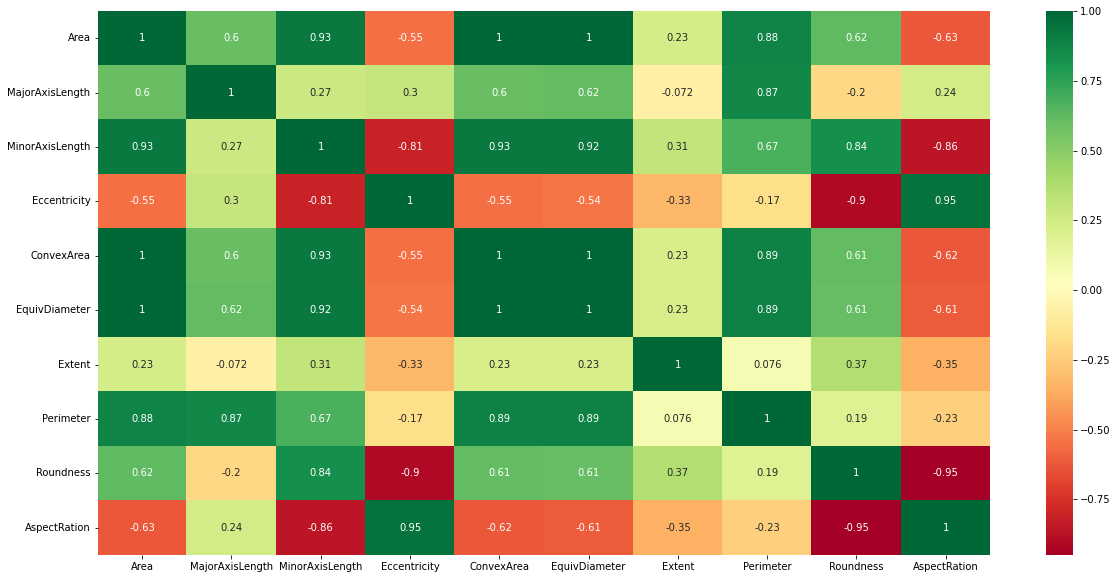

In [425]:
# Use Pearson Correlation 
cor = train[X].corr()
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True, cmap='RdYlGn')
plt.show() 



> This heatmap shows the correlation of all the features of the dataset. If the value is near to 1 that means those two features are correlated and we can drop any one of them.



In [426]:
# Customize function for selecting high-correlated features
def correlation(dataset, threshold):
    col_corr = []  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: colname = corr_matrix.columns[i]                  
    col_corr.append(colname)
    return col_corr

# Find the correlated features
corr_features = correlation(train[X], 0.85)
corr_features

['AspectRation']



> With the help of this function, I can select highly correlated features. The purpose is to select the correlated features and then remove them.





> In customized function "correlation(dataset, threshold)", we set threshold=0.85 which means the features which are 85% or more correlated will be returned in the output.





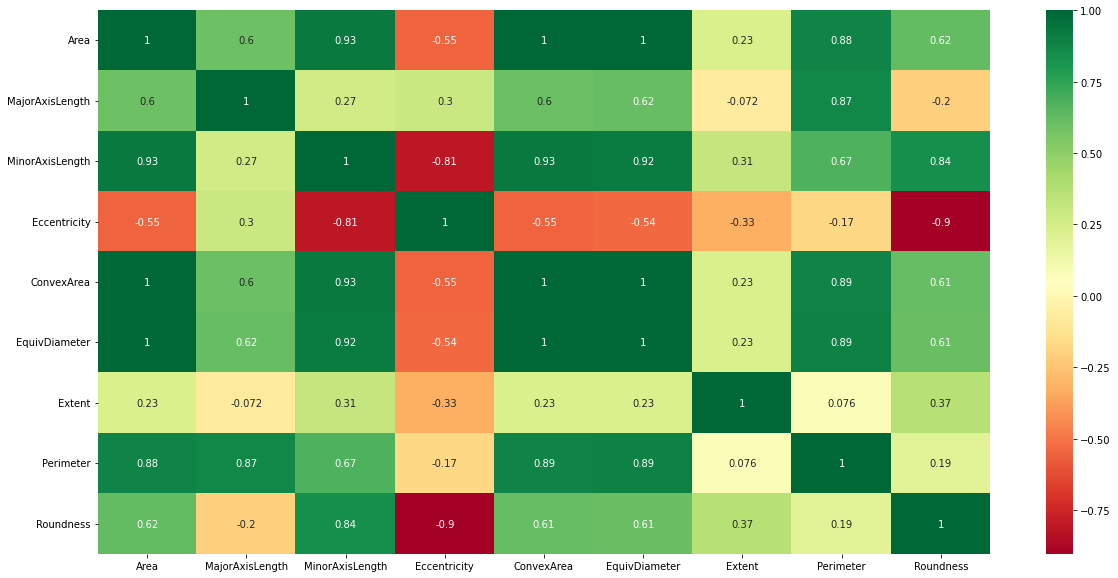

In [427]:
# Drop correlated features from train dataset
train.drop(corr_features, axis=1, inplace=True)
test.drop(corr_features, axis=1, inplace=True)

X = [c for c in X if c not in corr_features]

cor = train[X].corr()
plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True, cmap='RdYlGn')
plt.show()



> After feature selection, features remain in dataset are basically independent to each other, which will reduce the effect between high-correlated features.



## AutoML modeling

In [428]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ----------------------------------
H2O_cluster_uptime:         4 hours 42 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.3
H2O_cluster_version_age:    22 days
H2O_cluster_name:           H2O_from_python_unknownUser_aon1cj
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.939 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.16 final
--------------------------  ----------------------------------

In [429]:
# Transform dataframe to h2oframe
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [430]:
# For binary classification, response should be a factor. In this case rice class has been quantified to 1 and 0
model = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0, compute_p_values = True)
model.train(X, Y[0], training_frame= train_h2o, validation_frame = test_h2o)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1671149410964_117


GLM Model: summary
    family    link    regularization    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ----------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    binomial  logit   None              9                             9                              10                      Key_Frame__upload_afd7edf669bd8dc9e4d595497806432f.hex

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.0075876000836181574
RMSE: 0.08710683144058311
LogLoss: 0.029209424178718413
AUC: 0.9992444962569655
AUCPR: 0.9993780459127699
Gini: 0.9984889925139311
Null degrees of freedom: 14547
Residual degrees of freedom: 14538
Null deviance: 20011.214683905422
Residual deviance: 849.877405903991
AIC: 869.877405903991

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.385419370818021
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      6418  102   0.0156   (102.0/6520.0)
1      36    7992  0.0045   (36.0/8028.0)
Total  6454  8094  0.0095   (138.0/14548.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385419     0.99144   244
max f2                       0.227408     0.994361  277
max f0point5                 0.709829     0.992278  164
max accuracy                 0.385419     0.990514  244
max precision                0.999993     1         0
max recall                   0.000113174  1         398
max specificity              0.999993     1         0
max absolute_mcc             0.385419     0.980845  244
max min_per_class_accuracy   0.610464     0.989724  191
max mean_per_class_accuracy  0.520661     0.990157  210
max tns                      0.999993     6520      0
max fns                      0.999993     4585      0
max fps                      4.05109e-05  6520      399
max tps                      0.000113174  8028      398
max tnr                      0.999993     1         0
max fnr                      0.999993     0.571126  0
max fpr                      4.05109e-05  1         399
max tpr                      0.000113174  1         398

Gains/Lift Table: Avg response rate: 55.18 %, avg score: 51.63 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100357                   1.37262            1.72527   1.72527            0.952055         1.77689   0.952055                    1.77689             0.0173144       0.0173144                  72.5273   72.5273            0.0162408
2        0.0200027                   1.12836            1.43723   1.58175            0.793103         1.21695   0.872852                    1.49788             0.0143249       0.0316393                  43.7228   58.1746            0.0259644
3        0.0300385                   1.03864            0.819194  1.32698            0.452055         1.08015   0.732265                    1.35832             0.00822123      0.0398605                  -18.0806  32.698             0.0219157
4        0.0400055                   0.975502           0.724863  1.17697            0.4              1.00659   0.649485                    1.27069             0.00722471      0.0470852                  -27.5137  17.696

In [431]:
# Performance of validation in model
perf = model.model_performance(test_h2o)
perf

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.009376974785037635
RMSE: 0.09683478086430328
LogLoss: 0.03972980881918594
AUC: 0.9983707752390685
AUCPR: 0.9982953300517622
Gini: 0.996741550478137
Null degrees of freedom: 3636
Residual degrees of freedom: 3627
Null deviance: 5023.609776475716
Residual deviance: 288.99462935075843
AIC: 308.99462935075843

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2900547275753631
       0     1     Error    Rate
-----  ----  ----  -------  -------------
0      1648  32    0.019    (32.0/1680.0)
1      10    1947  0.0051   (10.0/1957.0)
Total  1658  1979  0.0115   (42.0/3637.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290055     0.989329  237
max f2                       0.0832048    0.993495  269
max f0point5                 0.846969     0.990884  184
max accuracy                 0.512127     0.988452  217
max precision                0.999996     1         0
max recall                   0.00439031   1         350
max specificity              0.999996     1         0
max absolute_mcc             0.290055     0.97682   237
max min_per_class_accuracy   0.572029     0.9875    214
max mean_per_class_accuracy  0.512127     0.988385  217
max tns                      0.999996     1680      0
max fns                      0.999996     1201      0
max fps                      1.37678e-05  1680      399
max tps                      0.00439031   1957      350
max tnr                      0.999996     1         0
max fnr                      0.999996     0.613694  0
max fpr                      1.37678e-05  1         399
max tpr                      0.00439031   1         350

Gains/Lift Table: Avg response rate: 53.81 %, avg score: 51.47 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------  --------------------
1        0.0101732                   1.44005            1.80823   1.80823            0.972973         1.89593   0.972973                    1.89593             0.0183955       0.0183955                  80.8228    80.8228            0.0178003
2        0.0200715                   1.14595            1.65196   1.73117            0.888889         1.2498    0.931507                    1.57729             0.0163516       0.0347471                  65.1962    73.1165            0.0317709
3        0.0302447                   1.0473             0.803657  1.41919            0.432432         1.08869   0.763636                    1.41294             0.00817578      0.0429228                  -19.6343   41.9185            0.0274467
4        0.040143                    0.985715           0.877605  1.28564            0.472222         1.01017   0.691781                    1.31363             0.00868677      0.0516096                  -12.2395   28.5645            0.0248239
5        0.0500412                   0.933458           0.980852  1.22536            0.527778         0.961044  0.659341                    1.24389             0.00970874      0.0613183                  -1.91478   22.5356            0.0244136
6        0.100082                    0.774755           0.663735  0.944545           0.357143         0.842974  0.508242                    1.04343             0.0332141       0.0945324                  -33.6265   -5.54546           -0.0120152
7        0.150124                    0.706623           0.816904  0.901998           0.43956          0.738669  0.485348                    0.94184

In [432]:
print(f"model's accuracy: {model.auc() * 100}%.")

model's accuracy: 99.92444962569655%.


## Model Intepretation

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

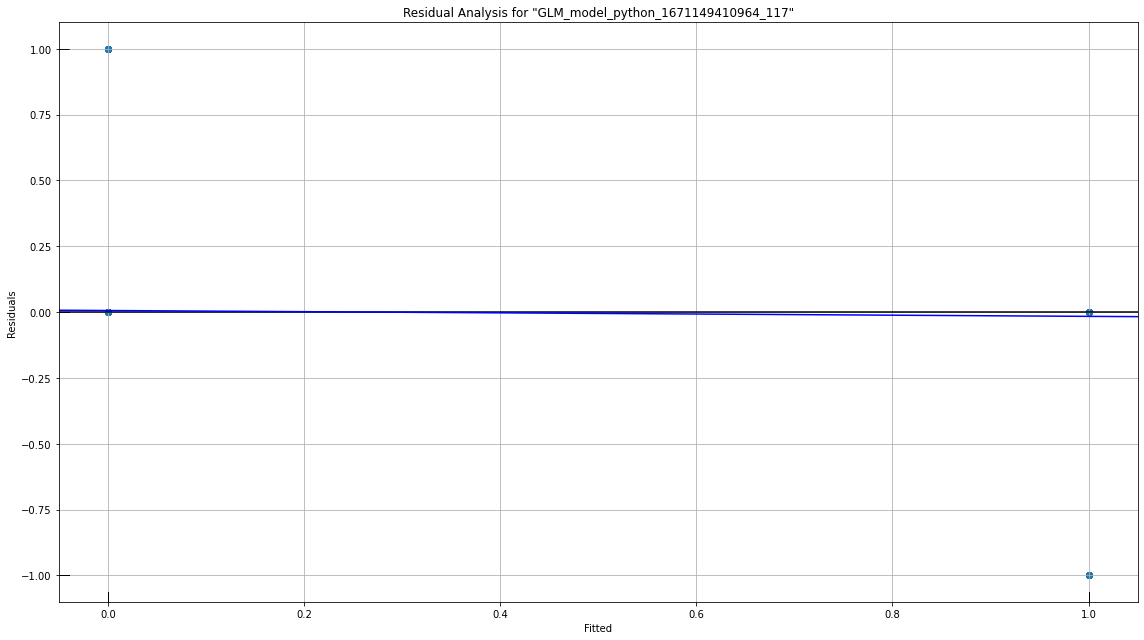

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

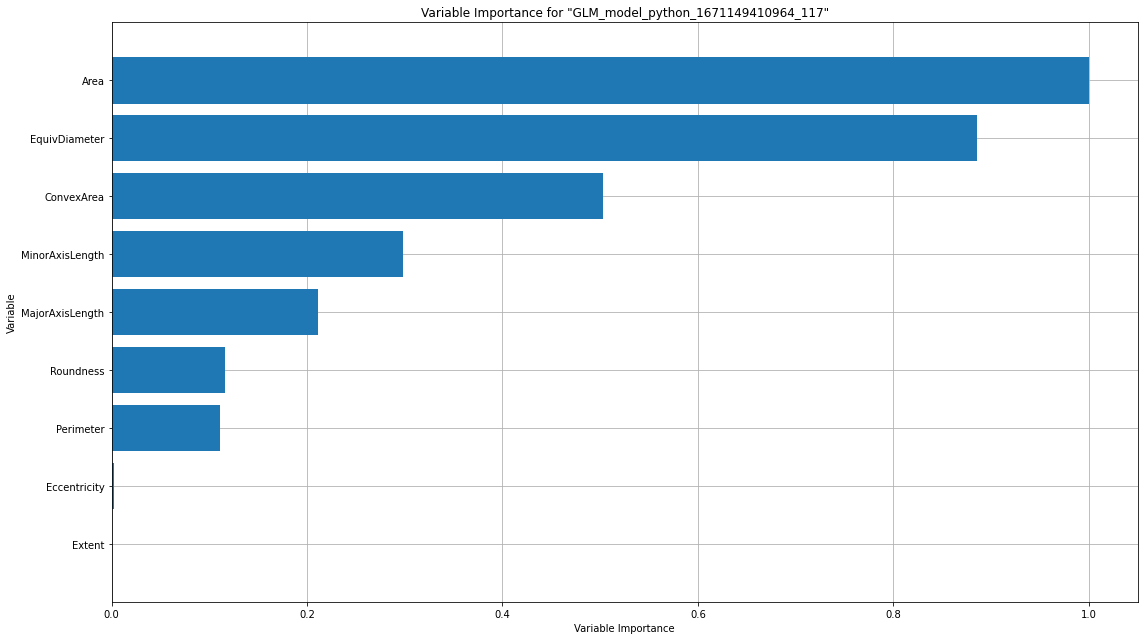

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

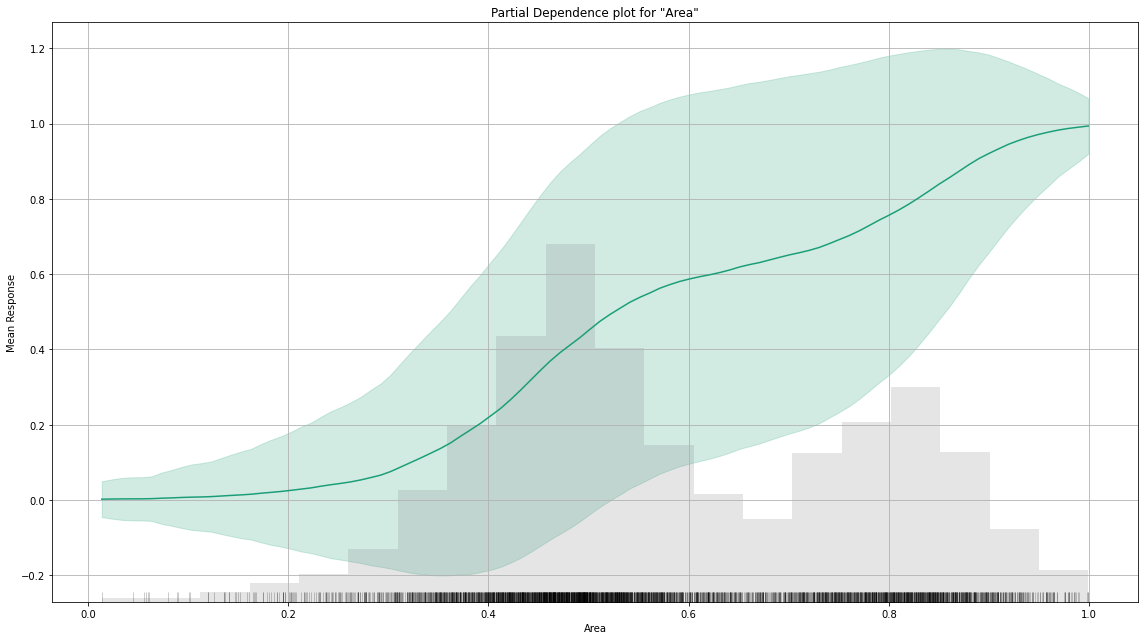

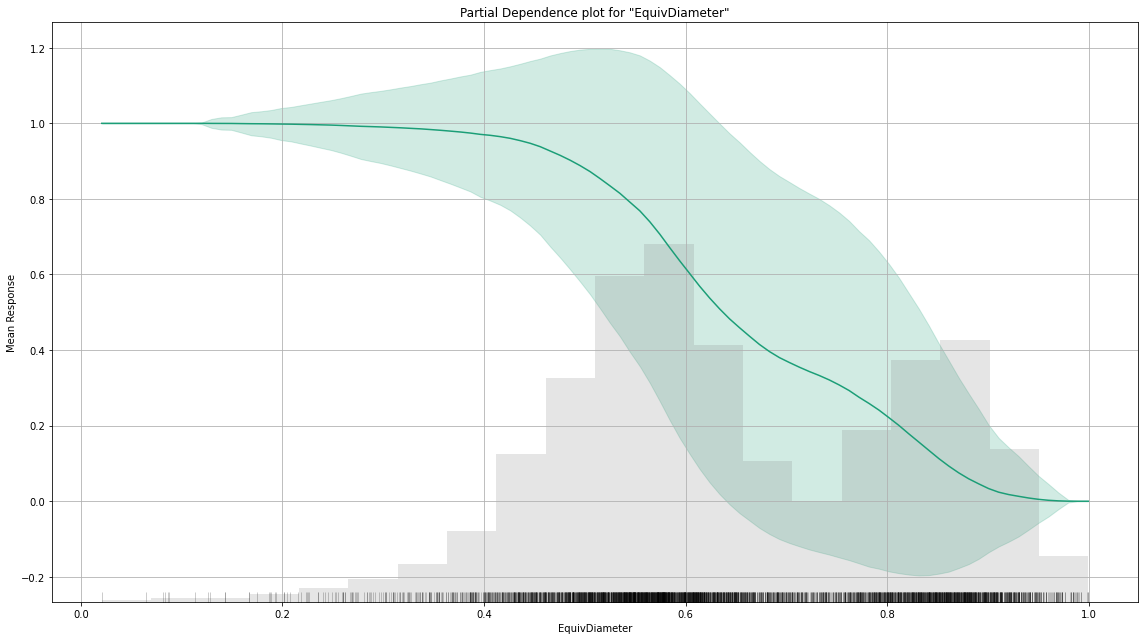

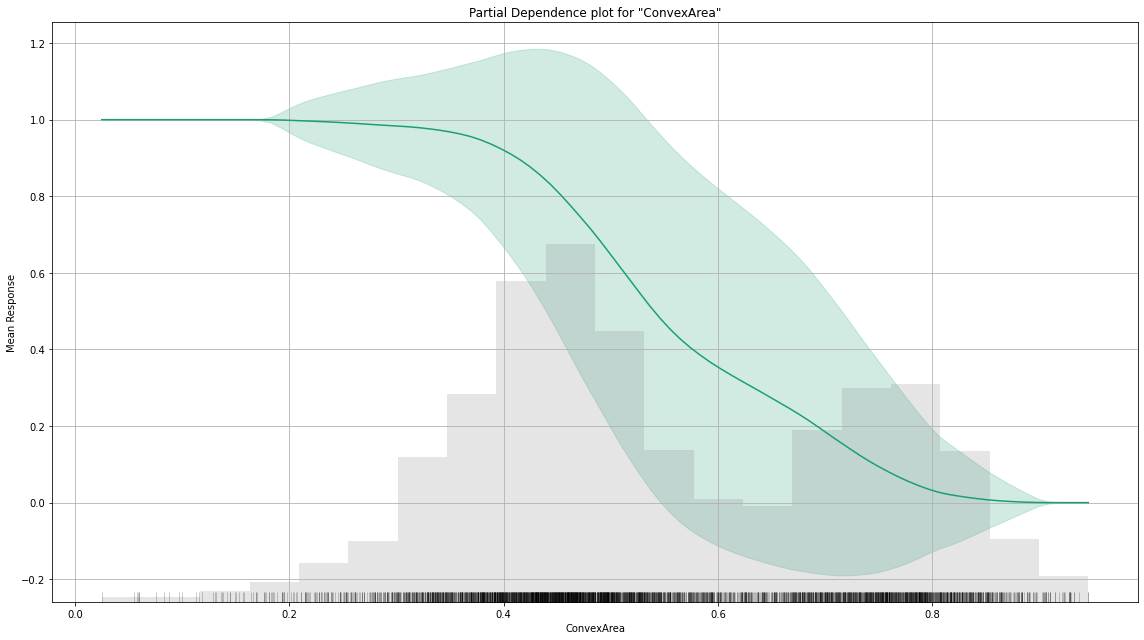

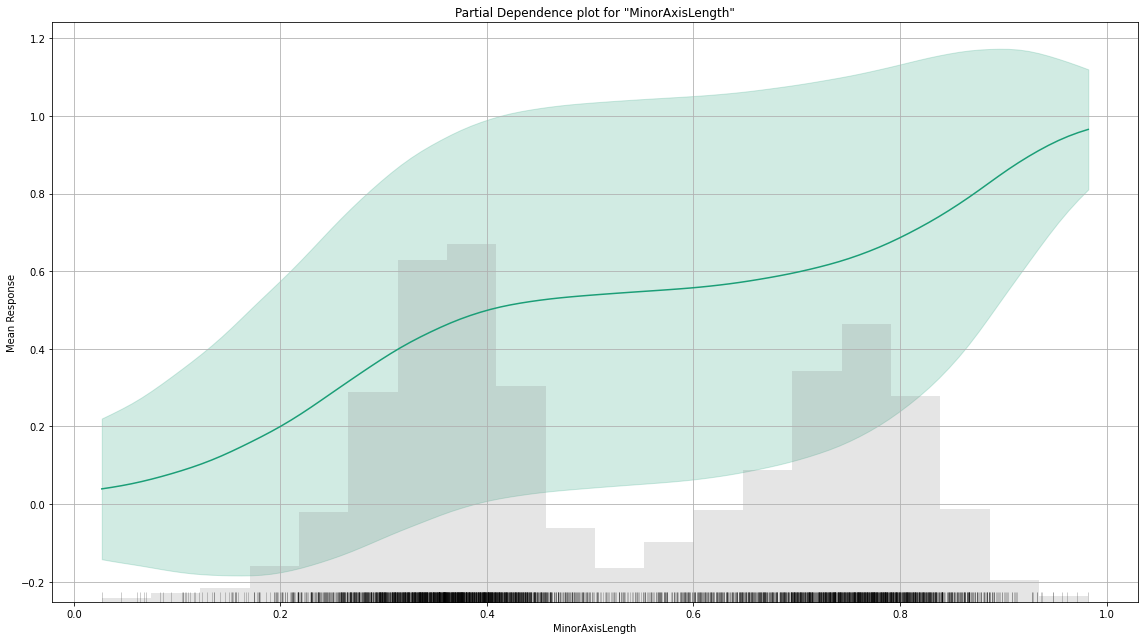

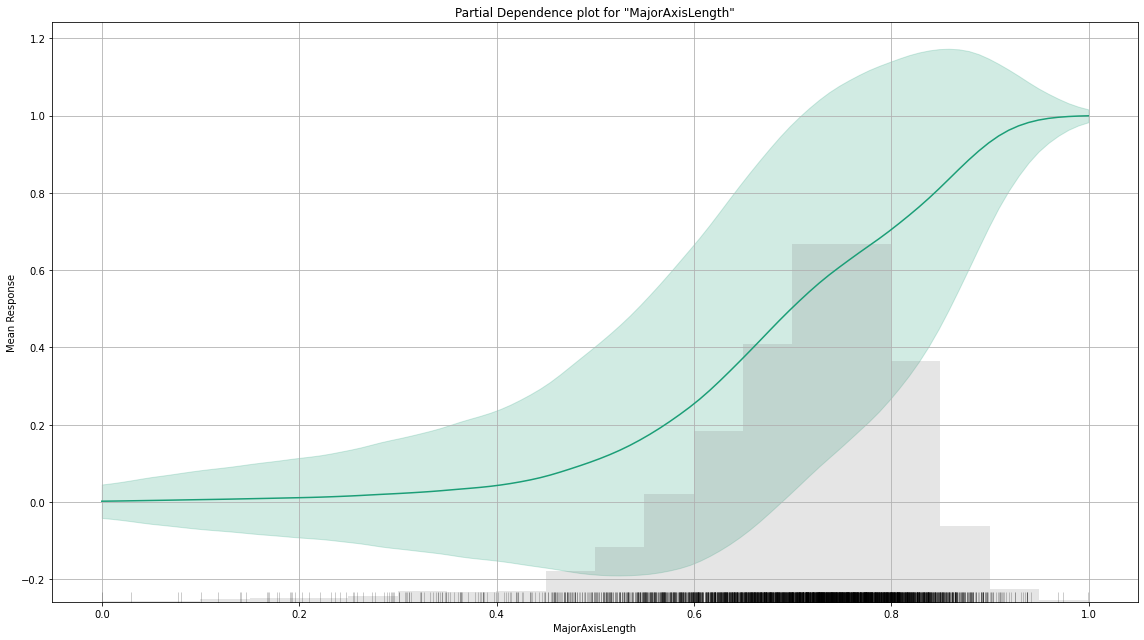

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

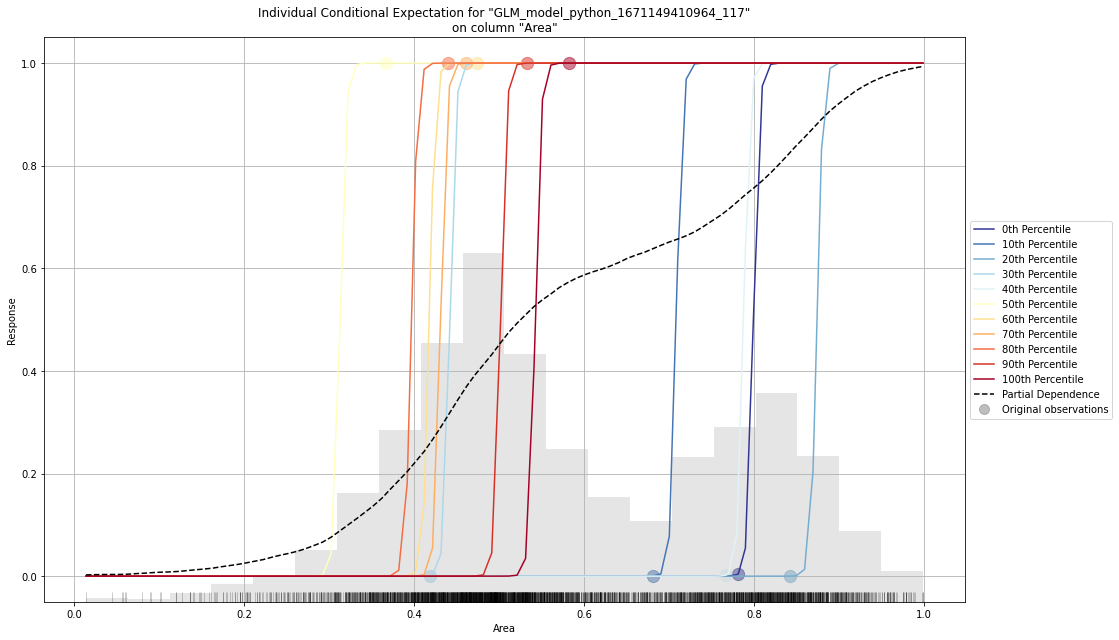

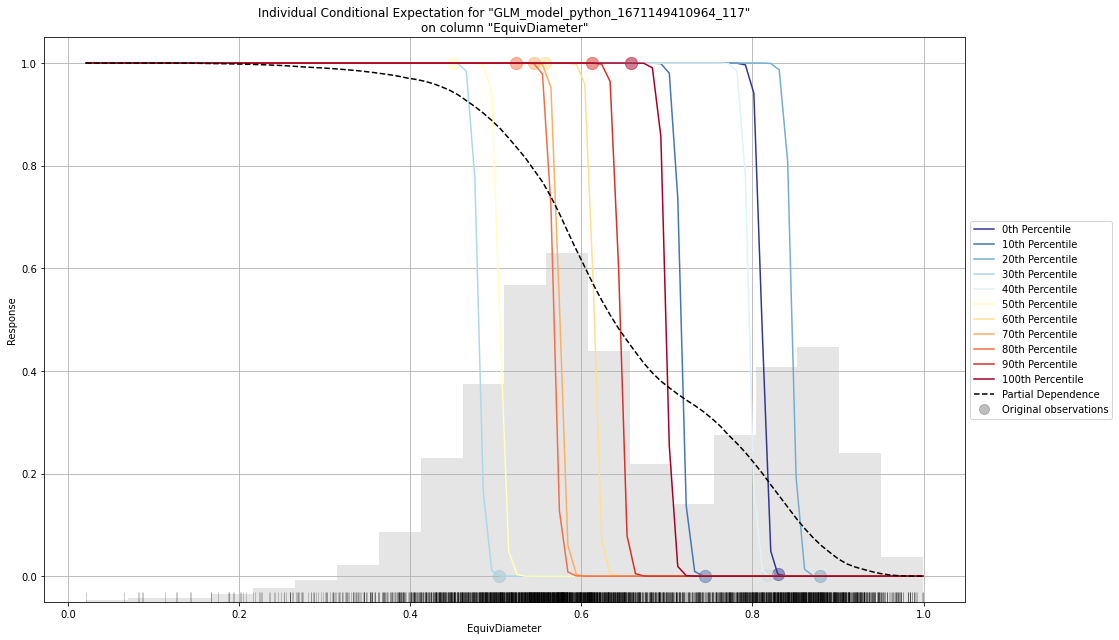

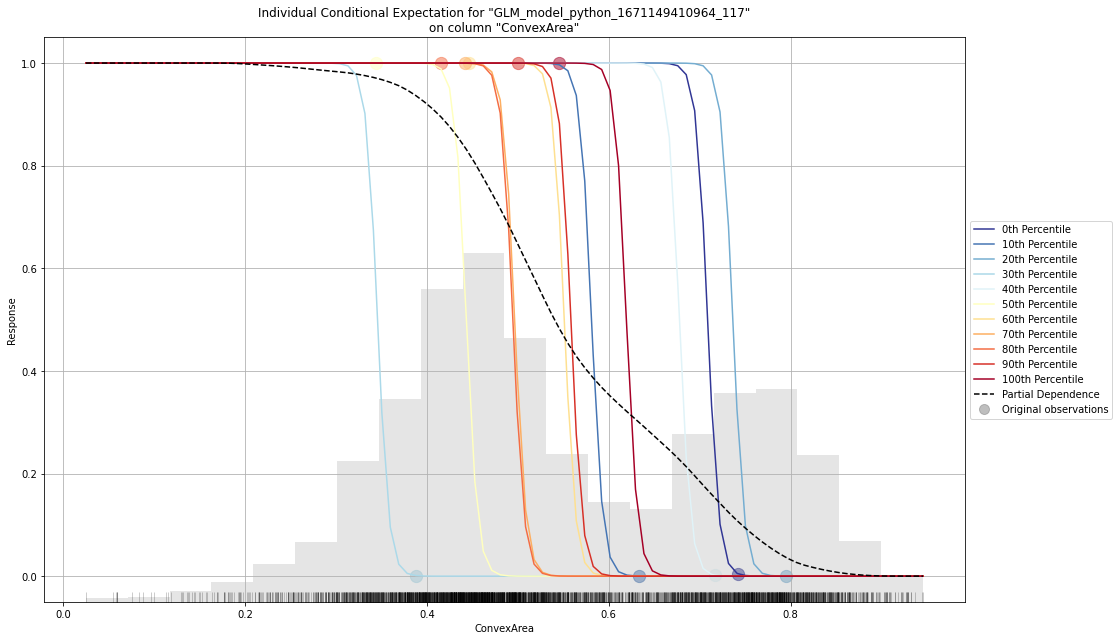

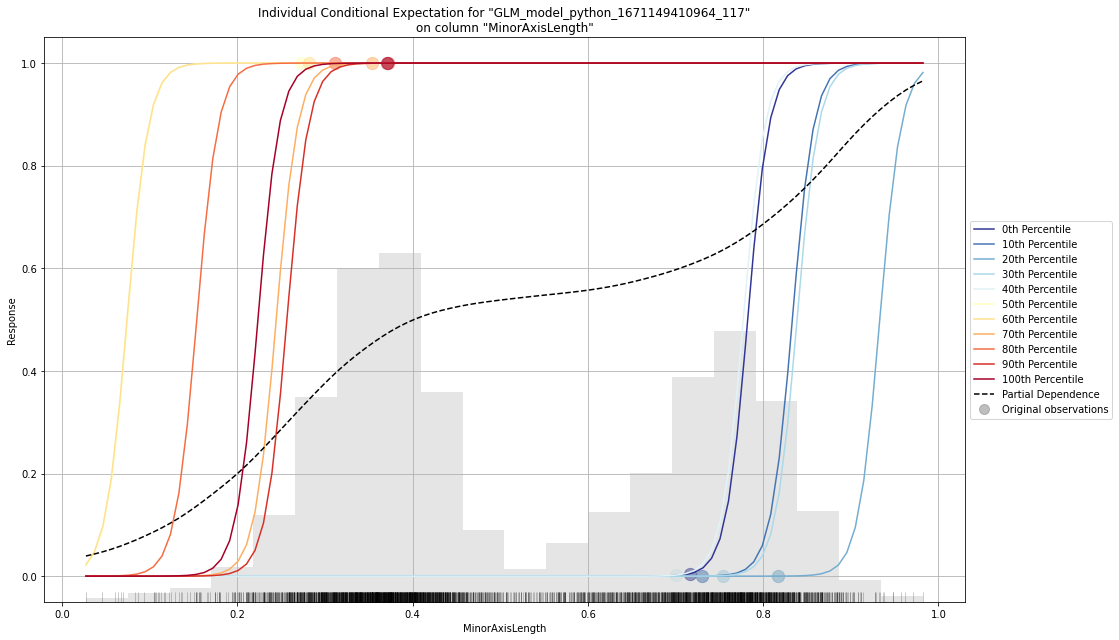

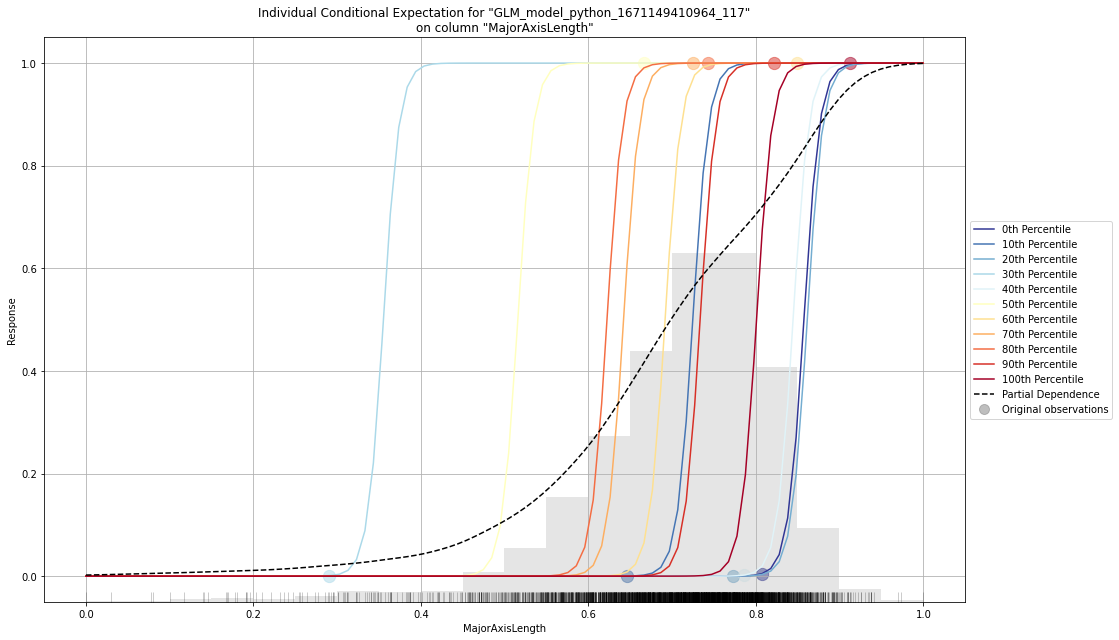

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [433]:
model.explain(test_h2o)

**Conclusion:**



> 1. "Residual Analysis" shows that model fit test dataset very well.
2. "variable importance" shows that "Area" has the strongest positive correlation with the prediction. "EquivDiameter" has the strongest negetive correlation with the prediction.
3. "Partial Dependence Plots" shows that different type of rice has different value range toward each variable, which means different tpyes of rice show striking differences in physical shape.
4. Among all variables, "ConvexArea" perform like logistic regression on predicting rice type.
5. Removing features which has high correlation with other features can improve accuracy of model by removing interference.


